#### write_based_data
True: Decide voltage based on average of real data<br>
False: Decide voltage based on average fitting model ->실제로는 가지도 못하는 resistance를 다루게 될 수 있음

원래 이론적으로는 target resistance도 결정한다, 그런데 target resistance를 결정 할 때 어쩔 수 없이 시그모이드함수가 들어간다.<br>
즉 write_based_data=True여도 실제로 generate 되는 resistance는 시그모이드와 함께 하기 때문에 실제로 generate 되는 resistance는 같다. <br>
음..쉽게 말하면 write_based_data가 True이든 False이든 결과에는 영향이 없다! 이 코드에서는 실질적인 변화를 위한 것이라기보다, data average와 fitting model average를 비교하기 위해 놓았다.<br>
(True로 놓으면 target resistance를 전자에서 가져오고,False로 놓으면 후자에서 가져온다).<br>

voltage를 어디서 결정할지도 사실 여기서 결정해야하지만 voltage는 미리 결정해놓았다고 가정한다.<br>
voltage를 fitting model에서 만들면 위에 언급한 문제가 발생한다. 즉 fitting모델은 특정구역에서 일반적 오차를 가져오는데 그 오차 때문에 실제로는 쓰기 힘든 resistance를 쓸 수 있다고 생각 하게 될 수도 있다. <br>
그래서 voltage를 고를 모델은 조금 더 신중하는게 좋다(오늘자 노트 참고).

#### read_based_data
True: Decide reference resistance based on average of real data<br>
False: Decide reference resistance based on average fitting model

In [2]:
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import pandas as pd
def make_index(x,ref):
    index = float(x>=ref[0])
    for ref in ref[1:]:
        index += float(x>=ref)
    return index
def load_info(num_level,choice=0):
    wb = load_workbook(filename='level_info.xlsx')
    sheetname = str(num_level) + 'Levels'
    if (str(wb.sheetnames).find(sheetname) > -1) and (wb[sheetname]['A' + str(3 * choice + 1)] != None):
        print("I find the information of %dLevels"%num_level)
        ws = wb[sheetname]
        volt = np.array([cell.value for cell in tuple(ws.rows)[3 * choice]]).astype('float32')
        r = np.array([cell.value for cell in tuple(ws.rows)[3 * choice+1]]).astype('float32')
        if ws['A' + str(3 * choice + 2)] != None:
            r_std = np.array([cell.value for cell in tuple(ws.rows)[3 * choice + 2]]).astype('float32')
        if ws['A' + str(3 * choice + 3)] != None:
            r_ref = np.array([cell.value for cell in tuple(ws.rows)[3 * choice + 3][1:]]).astype('float32')   #잘 read 되는지 확인해야함
            r_ref = (r[1:] + r[0:-1]) / 2
    else:
        print("There is no information  of %dLevels"%num_level)
        volt = np.array([simple_r for simple_r in range(1, num_level + 1)]).astype('float32')
        r = np.array([simple_r for simple_r in range(1, num_level + 1)]).astype('float32')
        r_std = np.ones([num_level], dtype='float32')
        r_ref = (r[1:] + r[0:-1]) / 2
    return volt,r,r_std,r_ref

In [90]:
def scheme_check(volt,r,r_std,r_ref,num_level=14,num_write=1000,fitting_model_average_choice=False,
                 write_based_data=False,read_based_data=False,cycle_variation=False,device_variation=False,onecell=False):
    log=np.zeros([num_level,num_write,5])
    log_level=np.zeros([num_level,num_level])
    a=3.156e+06
    b=4.463
    c=2.713
    d=2.509e+04
    if fitting_model_average_choice==False:
        mean_a,mean_b,mean_c,mean_d=a,b,c,d
    else:
        mean_a,mean_b,mean_c,mean_d=a*0.9996,b*1.0647,c*1.0004,d*1.0368
    if write_based_data == False: #
        r = np.array([mean_a / (1 + np.exp(-mean_b * (x - mean_c))) + mean_d for x in volt])
        
    if read_based_data == False:
        temp = np.array([mean_a / (1 + np.exp(-mean_b * (x - mean_c))) + mean_d for x in volt])
        r_ref = (temp[1:] + temp[0:-1]) / 2
#         r_ref = [ 508998.68485452,734426.74492238,1024890.55948719,1275528.5558163,1457834.55645558,1644133.88666727,1829306.37527018,2089524.18914522,2396897.257, 2640884.09748843,2820836.3687569,2979827.79184652,3099313.97217619]
#         r_ref=[ 553682.99450246,  777899.98328473, 1059132.06399215, 1298052.23847886,1470012.01854126, 1645204.55824665, 1819367.46320471, 2065746.25205046,2360407.67442528, 2599835.48980322, 2781688.95203013, 2949620.22106922,3081267.30830828]

    if cycle_variation == True: #True면 위에서 결정한거 그대로 쓰면 된다.
        meanofstd=0.6*r_std
        stdofstd=0.5*meanofstd
    else:
        meanofstd=np.zeros(len(r_std))
        stdofstd=np.zeros(len(r_std))
    
    if device_variation == True:
        std_a=abs(a)*0.0698
        std_b=abs(b)*0.1824
        std_c=abs(c)*0.0354
        std_d=abs(d)*0.7708
    else:
        std_a,std_b,std_c,std_d=0,0,0,0
        stdofstd=np.zeros(len(r_std))

    print("fitting_model_average_choice: \n[mean_a,mean_b,mean_c,mean_d]=",[mean_a,mean_b,mean_c,mean_d])
    print("write_based_data:\nr=",r)
    print("read_based_data:\nr_ref=",r_ref)
    print("cycle_variation:\nmeanofstd=",meanofstd,'\nstdofstd=',stdofstd)
    print("device_variation:\nstdofmean=",[std_a,std_b,std_c,std_d],"\nstdofstd=",stdofstd)
    cell_index=1
    cell_dict={}
    x_volt=np.linspace(1.7,4,231)
    cell_dict['Average Cell']=mean_a/(1+np.exp(-mean_b*(x_volt-mean_c))) + mean_d
    if onecell==True:
        a_var = np.random.normal(loc=mean_a, scale=std_a)
        b_var = np.random.normal(loc=mean_b, scale=std_b)
        c_var = np.random.normal(loc=mean_c, scale=std_c)
        d_var = np.random.normal(loc=mean_d, scale=std_d)
        cell_dict['Cell'+str(cell_index)]=a_var/(1+np.exp(-b_var*(x_volt-c_var))) + d_var
    for i in range(num_level):
        volt_write = volt[i]
        for j in range(num_write):
            if onecell==False:
                a_var = np.random.normal(loc=mean_a, scale=std_a)
                b_var = np.random.normal(loc=mean_b, scale=std_b)
                c_var = np.random.normal(loc=mean_c, scale=std_c)
                d_var = np.random.normal(loc=mean_d, scale=std_d)
                cell_dict['Cell'+str(cell_index).rjust(3,'0')]=a_var/(1+np.exp(-b_var*(x_volt-c_var))) + d_var
                cell_index+=1
            mean_val = a_var/(1+np.exp(-b_var*(volt_write-c_var))) + d_var
            std_val = np.random.normal(loc=meanofstd[i],scale=stdofstd[i])
            std_val = std_val *(std_val>0) + meanofstd[i]* (std_val<=0)
            r_write=np.random.normal(loc=mean_val,scale=std_val)
            level_read=make_index(r_write,r_ref)
            log[i,j,0]=i
            log[i,j,1]=r[i]
            log[i,j,2]=r_write
            log[i,j,3]=level_read
            log[i,j,4]=(i==level_read)
            log_level[i,int(level_read)]+=1
        print(mean_val)
        print([log[i, j, 0:3],mean_val,log[i,j,3],np.sum(log[i,:,4])])
        print(log_level[i,:])
    col_index=[1.7+0.01*i for i in range(231)]
    cell_function=pd.DataFrame(cell_dict, index=col_index)
    cell_function.plot()
    plt.show()
    print('finish')

In [21]:
volt,r,r_std,r_ref=load_info(num_level=36,choice=0)

I find the information of 14Levels


In [22]:
scheme_check(volt,r,r_std,r_ref,14,1000,fitting_model_average_choice=False,
             write_based_data=False,read_based_data=False,cycle_variation=False,device_variation=False)

fitting_model_average_choice: 
[mean_a,mean_b,mean_c,mean_d]= [3156000.0, 4.463, 2.713, 25090.0]
write_based_data:
r= [ 456423.69687235  650942.29213256  904857.6744369  1213406.45354739
 1382698.02341033 1557326.01367219 1733083.1028211  1905651.82358832
 2225840.68051259 2494974.66833797 2704696.31126847 2858681.59279179
 3040558.84934666 3121975.7672699 ]
read_based_data:
r_ref= [553682.99450246, 777899.98328473, 1059132.06399215, 1298052.23847886, 1470012.01854126, 1645204.55824665, 1819367.46320471, 2065746.25205046, 2360407.67442528, 2599835.48980322, 2781688.95203013, 2949620.22106922, 3081267.30830828]
cycle_variation:
meanofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
device_variation:
stdofmean= [0, 0, 0, 0] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([     0.        , 456423.69687235, 456423.69687235,      0.        ]), 1000.0]
[array([1.00000000e+00, 6.50942292e+05, 6.50942292e+05, 1.00000000e+00])

In [23]:
scheme_check(volt,r,r_std,r_ref,14,1000,fitting_model_average_choice=False,
             write_based_data=False,read_based_data=False,cycle_variation=False,device_variation=False)

fitting_model_average_choice: 
[mean_a,mean_b,mean_c,mean_d]= [3156000.0, 4.463, 2.713, 25090.0]
write_based_data:
r= [ 456423.69687235  650942.29213256  904857.6744369  1213406.45354739
 1382698.02341033 1557326.01367219 1733083.1028211  1905651.82358832
 2225840.68051259 2494974.66833797 2704696.31126847 2858681.59279179
 3040558.84934666 3121975.7672699 ]
read_based_data:
r_ref= [553682.99450246, 777899.98328473, 1059132.06399215, 1298052.23847886, 1470012.01854126, 1645204.55824665, 1819367.46320471, 2065746.25205046, 2360407.67442528, 2599835.48980322, 2781688.95203013, 2949620.22106922, 3081267.30830828]
cycle_variation:
meanofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
device_variation:
stdofmean= [0, 0, 0, 0] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([     0.        , 456423.69687235, 456423.69687235,      0.        ]), 1000.0]
[array([1.00000000e+00, 6.50942292e+05, 6.50942292e+05, 1.00000000e+00])

위 두개의 예는 fitting_model_average_choice만 다릅니다, 이를 통해 mean of a,b,c,d를 실제 데이터 mean에 기반한(false)와 실제 데이터 fitting model의 평균에 기반한(True)의 차이가 그렇게 크지 않다는 것을 알 수 있습니다.(즉 서로 섞어써도 레벨을 인식하는데 무리가 없다) 
레벨이 올라가면 저 조금의 차이도 인식에 차이를 가져오긴 하겠지만, variation을 고려한다면 그렇게 significant한 영향을 줄 것 같지는 않습니다.

주의:write_based_data=False일 때만(최소한 read_based_data=False여야) fitting_model_average_choice의 true/false가 의미가 있습니다. fitting model의 평균을 뭘로 할 것이냐를 결정하는데, 만약 fitting model을 안쓰면 의미가 없겠죠?

In [40]:
scheme_check(volt,r,r_std,r_ref,14,1000,fitting_model_average_choice=False,
             write_based_data=True,read_based_data=False,cycle_variation=False,device_variation=False)

fitting_model_average_choice: 
[mean_a,mean_b,mean_c,mean_d]= [3154737.6, 4.7517561, 2.7140852, 26013.311999999998]
write_based_data:
r= [ 408093.4   647025.06  968410.6  1275442.1  1394173.8  1586317.6
 1773990.4  1923664.4  2242287.5  2431918.8  2699296.   2782773.5
 2998088.2  3142365.2 ]
read_based_data:
r_ref= [ 508998.68485452  734426.74492238 1024890.55948719 1275528.5558163
 1457834.55645558 1644133.88666727 1829306.37527018 2089524.18914522
 2396897.25713225 2640884.09748843 2820836.3687569  2979827.79184652
 3099313.97217619]
cycle_variation:
meanofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
device_variation:
stdofmean= [0, 0, 0, 0] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([     0.        , 408093.40625   , 412921.21487398,      0.        ]), 1000.0]
[array([1.00000000e+00, 6.47025062e+05, 6.05076155e+05, 1.00000000e+00]), 1000.0]
[array([2.00000000e+00, 9.68410625e+05, 8.63777335e+05, 2.00000000

In [41]:
scheme_check(volt,r,r_std,r_ref,14,1000,fitting_model_average_choice=False,
             write_based_data=False,read_based_data=True,cycle_variation=False,device_variation=False)

fitting_model_average_choice: 
[mean_a,mean_b,mean_c,mean_d]= [3156000.0, 4.463, 2.713, 25090.0]
write_based_data:
r= [ 456423.69687235  650942.29213256  904857.6744369  1213406.45354739
 1382698.02341033 1557326.01367219 1733083.1028211  1905651.82358832
 2225840.68051259 2494974.66833797 2704696.31126847 2858681.59279179
 3040558.84934666 3121975.7672699 ]
read_based_data:
r_ref= [ 527559.25  807717.9  1121926.4  1334808.   1490245.8  1680154.
 1848827.4  2082976.   2337103.   2565607.5  2741034.8  2890431.
 3070226.8 ]
cycle_variation:
meanofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
device_variation:
stdofmean= [0, 0, 0, 0] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([     0.        , 456423.69687235, 456423.69687235,      0.        ]), 1000.0]
[array([1.00000000e+00, 6.50942292e+05, 6.50942292e+05, 1.00000000e+00]), 1000.0]
[array([2.00000000e+00, 9.04857674e+05, 9.04857674e+05, 2.00000000e+00]), 1000.0

위 두개의 예는 write_based_data,read_based_data가 다릅니다. True일 경우 data average를 기반으로 하고, False일 경우 fitting model average를 기반으로 하는데 0-1V, ~4V라는 fitting quality가 낮은 구역을 제외한 레벨들이기 때문에 서로 섞어써도 별 차이가 없는 것을 알 수 있습니다.
이 부분 역시 레벨 수가 커지면 영향이 생기기는 하겠지만 마찬가지로 variation 영향 속에서 significant하지는 않을 듯 합니다.

In [42]:
scheme_check(volt,r,r_std,r_ref,14,1000,fitting_model_average_choice=True,
             write_based_data=False,read_based_data=False,cycle_variation=True,device_variation=False)

fitting_model_average_choice: 
[mean_a,mean_b,mean_c,mean_d]= [3154737.6, 4.7517561, 2.7140852, 26013.311999999998]
write_based_data:
r= [ 412921.21487398  605076.15483507  863777.33500968 1186003.78396469
 1365053.3276679  1550615.78524327 1737651.98809127 1920960.76244909
 2258087.61584135 2535706.89842316 2746061.2965537  2895611.44096009
 3064044.14273295 3134583.80161944]
read_based_data:
r_ref= [ 508998.68485452  734426.74492238 1024890.55948719 1275528.5558163
 1457834.55645558 1644133.88666727 1829306.37527018 2089524.18914522
 2396897.25713225 2640884.09748843 2820836.3687569  2979827.79184652
 3099313.97217619]
cycle_variation:
meanofstd= [133882.2  122234.07 220532.75 250271.67 237156.48 261253.06 246720.44
 219977.48 211311.81 220284.16 192955.4  171979.44 169466.98 157368.23] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
device_variation:
stdofmean= [0, 0, 0, 0] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([     0.        , 412921.21487398, 207838

In [25]:
scheme_check(volt,r,r_std,r_ref,14,1000,fitting_model_average_choice=True,
             write_based_data=False,read_based_data=False,cycle_variation=False,device_variation=True)

fitting_model_average_choice: 
[mean_a,mean_b,mean_c,mean_d]= [3154737.6, 4.7517561, 2.7140852, 26013.311999999998]
write_based_data:
r= [ 412921.21487398  605076.15483507  863777.33500968 1186003.78396469
 1365053.3276679  1550615.78524327 1737651.98809127 1920960.76244909
 2258087.61584135 2535706.89842316 2746061.2965537  2895611.44096009
 3064044.14273295 3134583.80161944]
read_based_data:
r_ref= [ 508998.68485452  734426.74492238 1024890.55948719 1275528.5558163
 1457834.55645558 1644133.88666727 1829306.37527018 2089524.18914522
 2396897.25713225 2640884.09748843 2820836.3687569  2979827.79184652
 3099313.97217619]
cycle_variation:
meanofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
device_variation:
stdofmean= [220288.80000000002, 0.8140512000000001, 0.0960402, 19339.372] 
stdofstd= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([     0.        , 412921.21487398, 120735.56513423,      0.        ]), 656.0]
[array([1.00

위의 두 예를 통해 당연하지만 device_variation의 영향이 cycle_variation보다 큰걸 알 수 있습니다

I find the information of 16Levels
fitting_model_average_choice: 
[mean_a,mean_b,mean_c,mean_d]= [3154737.6, 4.7517561, 2.7140852, 26013.311999999998]
write_based_data:
r= [  61155.27593001  267474.52664426  482202.35715172  700381.9245092
  893338.11520616 1117215.63448026 1328570.38040158 1550615.78524327
 1774774.70072795 1992140.62603373 2194847.86297998 2405240.62998977
 2605787.12360004 2812523.23946196 3020330.95512241 3173763.64284554]
read_based_data:
r_ref= [ 164314.90128713  374838.44189799  591292.14083046  796860.01985768
 1005276.87484321 1222893.00744092 1439593.08282243 1662695.24298561
 1883457.66338084 2093494.24450685 2300044.24648487 2505513.8767949
 2709155.181531   2916427.09729218 3097047.29898398]
cycle_variation:
meanofstd= [  7687.0293 111016.586  172245.03   163174.28   231089.31   249086.64
 251062.75   261253.06   274198.56   245157.73   202493.7    198167.94
 207318.5    193427.67   145129.94   167212.72  ] 
stdofstd= [  3843.5146  55508.293   86122.516   

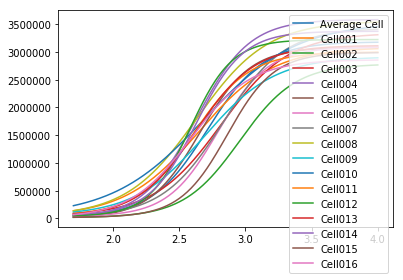

finish


In [93]:
num_level=16
volt,r,r_std,r_ref=load_info(num_level=num_level,choice=0)
scheme_check(volt,r,r_std,r_ref,num_level,1,fitting_model_average_choice=True,
             write_based_data=False,read_based_data=False,cycle_variation=True,device_variation=True,onecell=False)



{'ddd': [1, 2, 3, 4, 5], 'low': [1898000, 1885000, 1903000, 1951000, 1949000], 'open': [1903000, 1901000, 1948000, 1951000, 1950000], 'close': [1922000, 1903000, 1911000, 1959000, 1965000], 'high': [1938000, 1907000, 1955000, 1972000, 1967000]}
              close  ddd     high      low     open
2017.02.28  1922000    1  1938000  1898000  1903000
2017.02.27  1903000    2  1907000  1885000  1901000
2017.02.24  1911000    3  1955000  1903000  1948000
2017.02.23  1959000    4  1972000  1951000  1951000
2017.02.22  1965000    5  1967000  1949000  1950000
AxesSubplot(0.125,0.125;0.775x0.755)


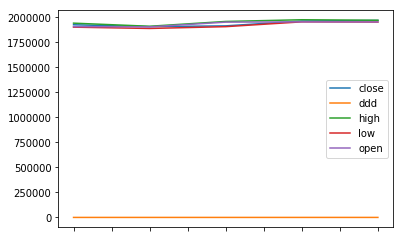

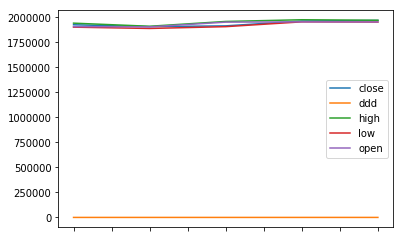

[1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81 1.82 1.83
 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95 1.96 1.97
 1.98 1.99 2.   2.01 2.02 2.03 2.04 2.05 2.06 2.07 2.08 2.09 2.1  2.11
 2.12 2.13 2.14 2.15 2.16 2.17 2.18 2.19 2.2  2.21 2.22 2.23 2.24 2.25
 2.26 2.27 2.28 2.29 2.3  2.31 2.32 2.33 2.34 2.35 2.36 2.37 2.38 2.39
 2.4  2.41 2.42 2.43 2.44 2.45 2.46 2.47 2.48 2.49 2.5  2.51 2.52 2.53
 2.54 2.55 2.56 2.57 2.58 2.59 2.6  2.61 2.62 2.63 2.64 2.65 2.66 2.67
 2.68 2.69 2.7  2.71 2.72 2.73 2.74 2.75 2.76 2.77 2.78 2.79 2.8  2.81
 2.82 2.83 2.84 2.85 2.86 2.87 2.88 2.89 2.9  2.91 2.92 2.93 2.94 2.95
 2.96 2.97 2.98 2.99 3.   3.01 3.02 3.03 3.04 3.05 3.06 3.07 3.08 3.09
 3.1  3.11 3.12 3.13 3.14 3.15 3.16 3.17 3.18 3.19 3.2  3.21 3.22 3.23
 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31 3.32 3.33 3.34 3.35 3.36 3.37
 3.38 3.39 3.4  3.41 3.42 3.43 3.44 3.45 3.46 3.47 3.48 3.49 3.5  3.51
 3.52 3.53 3.54 3.55 3.56 3.57 3.58 3.59 3.6  3.61 3.62 3.63 3.64 3.65
 3.66 

In [99]:
date = ['2017.02.22', '2017.02.23', '2017.02.24', '2017.02.27', '2017.02.28']
raw_data = {'open': [1903000, 1901000, 1948000, 1951000, 1950000],
            'close': [1922000, 1903000, 1911000, 1959000, 1965000],
            'high': [1938000, 1907000, 1955000, 1972000, 1967000],
            'low': [1898000, 1885000, 1903000, 1951000, 1949000]}
raw_data['ddd']=[1,2,3,4,5]
print(raw_data)
samsung2 = pd.DataFrame(raw_data, index=reversed(date))
print(samsung2)
samsung2.plot()
print(samsung2.plot())
plt.show()
print(np.linspace(1.7,4,231))
col_index=[1.7+0.01*i for i in range(231)]

'ddd00'